# PPO Discrete in Cart Pole Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

from rlforge.environments import Pendulum
from rlforge.agents.policy_gradient import PPODiscrete
from rlforge.experiments import ExperimentRunner

In [2]:
import torch
if torch.cuda.is_available():
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
else:
    print("CUDA is not available.")

Number of CUDA devices: 1


In [3]:
env = gym.make("CartPole-v1")
agent = PPODiscrete(
    state_dim=env.observation_space.shape[0],  
    num_actions=env.action_space.n,       
    actor_lr=0.0003,
    critic_lr=0.002,
    discount=0.99,
    clip_epsilon=0.2,
    network_architecture=[64,64],
    update_epochs=10,
    mini_batch_size=64,
    rollout_length=1024,
    value_coef=0.5,
    entropy_coeff=0.01,
    gae_lambda=0.95,
    device='cpu'
)

In [4]:
runner = ExperimentRunner(env, agent)

results = runner.run_episodic(
    num_runs=1,
    num_episodes=300,
    max_steps_per_episode=None
)

rewards = results["rewards"]

runner.summary(last_n=20)

 Experiment Summary (Episodic)
Runs: 1
Average runtime per run: 66.055 seconds
Episodes per run: 300
First episode mean reward: 19.000
Last episode mean reward: 500.000
Overall mean reward: 248.570
Mean reward (last 20 episodes): 417.100
First episode mean steps: 19.0
Last episode mean steps: 500.0
Overall mean steps: 248.6


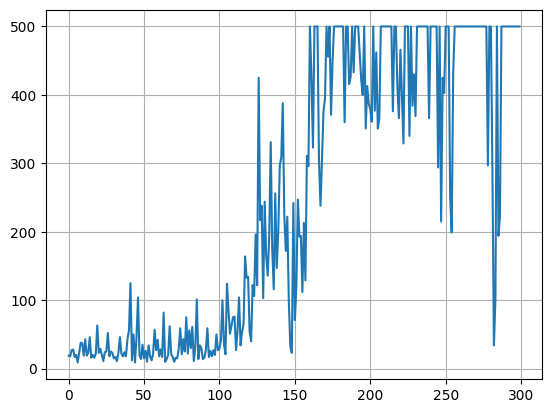

In [6]:
runs_std = np.std(rewards, axis=1)
runs_mean = np.mean(rewards, axis=1)
lower_bound = runs_mean - runs_std
upper_bound = runs_mean + runs_std
plt.plot(runs_mean)
plt.fill_between(np.arange(len(runs_mean)), lower_bound, upper_bound, alpha=0.3)
plt.grid()

In [11]:
agent.reset()
num_envs = 8
envs = gym.make_vec("CartPole-v1", num_envs=num_envs, vectorization_mode="async")

runner = ExperimentRunner(envs, agent)

results = runner.run_episodic_batch(
    num_runs=10,
    num_episodes=500,
    max_steps_per_episode=None
)

rewards = results["rewards"]

runner.summary(last_n=20)

 Experiment Summary (Episodic)
Runs: 10
Average runtime per run: 101.038 seconds
Episodes per run: 500
First episode mean reward: 12.400
Last episode mean reward: 496.300
Overall mean reward: 324.532
Mean reward (last 20 episodes): 475.665
First episode mean steps: 12.4
Last episode mean steps: 497.3
Overall mean steps: 325.5


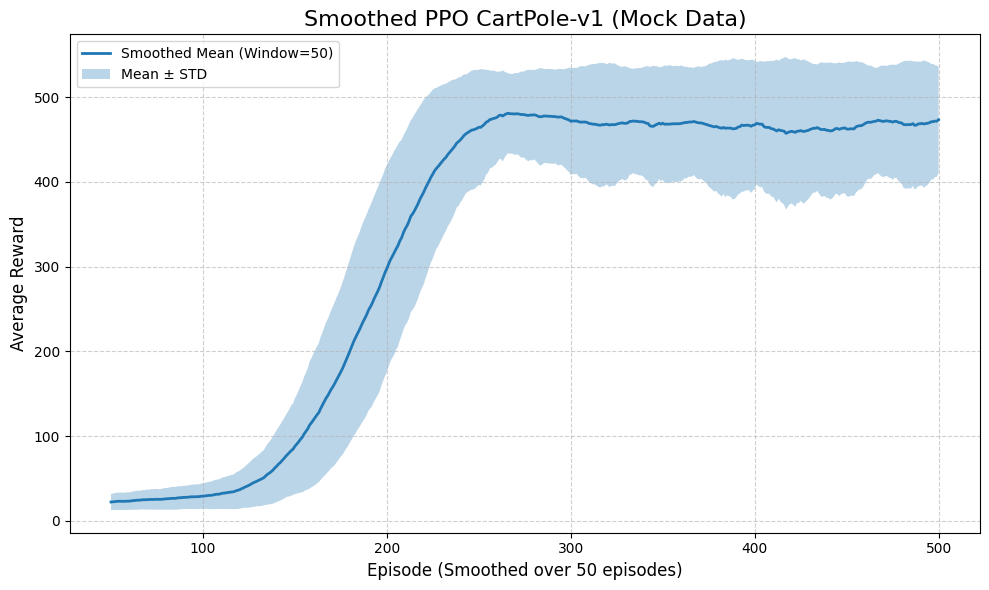

In [14]:
def moving_average(data, window_size):
    """
    Computes the simple moving average (SMA) of a 1D array.
    """
    # Create an array of ones with size `window_size`
    window = np.ones(window_size) / window_size
    # Convolve the data with the window. 'valid' mode means results are only
    # given where the window fully overlaps the data.
    # This shortens the resulting array by (window_size - 1).
    return np.convolve(data, window, 'valid')

def plot_smoothed_rewards(rewards, window_size=50, title="PPO Continuous Learning Curve"):
    """
    Calculates mean and standard deviation across multiple runs, then smooths both
    using a moving average for cleaner visualization.

    Args:
        rewards (np.ndarray): 2D array of rewards (episodes, runs).
        window_size (int): The window size for the moving average.
        title (str): Title for the plot.
    """
    if rewards.ndim != 2:
        raise ValueError("Rewards must be a 2D array (episodes x runs).")

    # 1. Calculate Mean and STD across runs at each time step (episode)
    runs_mean = np.mean(rewards, axis=1) # (episodes,)
    runs_std = np.std(rewards, axis=1)   # (episodes,)
    
    # 2. Smooth the Mean and STD
    # Note: We must smooth the mean and the std separately.
    smoothed_mean = moving_average(runs_mean, window_size)
    smoothed_std = moving_average(runs_std, window_size)
    
    # The smoothed arrays are shorter than the original
    n_points = len(smoothed_mean)
    x_axis = np.arange(window_size, window_size + n_points)

    # 3. Calculate the Bounds for the filled area
    lower_bound = smoothed_mean - smoothed_std
    upper_bound = smoothed_mean + smoothed_std

    # 4. Plotting
    plt.figure(figsize=(10, 6))
    
    # Plot the smoothed mean line
    plt.plot(x_axis, smoothed_mean, label=f'Smoothed Mean (Window={window_size})', linewidth=2)
    
    # Fill the area for the smoothed standard deviation (mean ± std)
    plt.fill_between(x_axis, lower_bound, upper_bound, alpha=0.3, label=f'Mean ± STD')
    
    plt.title(title, fontsize=16)
    plt.xlabel(f'Episode (Smoothed over {window_size} episodes)', fontsize=12)
    plt.ylabel('Average Reward', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_smoothed_rewards(rewards, window_size=50, title="Smoothed PPO CartPole-v1")